# Penn Libraries MMSID Removal Analyzer
- Place your list of MMS IDs in `mmsid_list.txt` inside `input_dir`
- Run the single code cell below to generate `mmsid_removal_report_<timestamp>.csv` inside `output_dir` 
- The report will show if a given Penn MMSID was found to be unique or was removed. The report includes the stage from the pod-processing.ipynb which is was removed, and the reason for non-uniqueness.

In [36]:
# This cell is self-contained: it sets up Spark if needed, defines minimal helpers,
# reads MMS IDs from a specified file or input_dir, analyzes, and writes a CSV to output_dir.

import os
import pathlib
import re
from datetime import datetime

import pandas as pd

# 1) Spark bootstrap (if not already present)
try:
    spark  # noqa: F821
except NameError:
    from pyspark.sql import SparkSession

    spark = SparkSession.builder.appName("post-processing-removal-analyzer").getOrCreate()
import pyspark.sql.functions as F

# 2) Resolve paths and configuration
# Preferred locations provided by user
_base_parquet_dir_candidates = [
    "work/July-2025-PODParquet/initial_parquet",
    "/home/jovyan/work/July-2025-PODParquet/initial_parquet",
]
_output_dir_candidates = [
    "work/July-2025-PODParquet/pod-processing-outputs",
    "/home/jovyan/work/July-2025-PODParquet/pod-processing-outputs",
    "pod-processing-outputs",
]
_mmsid_file_candidates = [
    "work/July-2025-PODParquet/pod-processing-outputs/fifty-of-penn-100.txt",
    "/home/jovyan/work/July-2025-PODParquet/pod-processing-outputs/fifty-of-penn-100.txt",
]

def _first_existing(paths):
    for p in paths:
        if p and os.path.exists(p):
            return p
    return None

# Output directory (where stage files and results live)
try:
    output_dir  # noqa: F821
except NameError:
    output_dir = _first_existing(_output_dir_candidates) or _output_dir_candidates[0]
os.makedirs(output_dir, exist_ok=True)

# Input directory (legacy fallback when not using explicit file)
try:
    input_dir  # noqa: F821
except NameError:
    input_dir = output_dir

# Base parquet directory for Penn source MARC
base_parquet_dir = _first_existing(_base_parquet_dir_candidates) or output_dir

# Optional explicit MMSID file; fallback to input_dir/mmsid_list.txt
mmsid_file = _first_existing(_mmsid_file_candidates)

# 3) Minimal helpers (kept local to this cell)
def _safe_title(val, max_len=120):
    if val is None:
        return None
    try:
        text = str(val)
    except Exception:
        return None
    return text[:max_len]

def _extract_oclc_number(oclc_string):
    match = re.search(r"\(OCoLC\)(?:ocm|ocn)?(\d+)", str(oclc_string))
    return match.group(1) if match else None

def _check_file_presence(mmsid, filepath, id_column="F001", sheet_hint=None):
    if not os.path.exists(filepath):
        return None
    try:
        if filepath.endswith(".parquet"):
            df = spark.read.parquet(filepath)
            return df.filter(F.col(id_column) == mmsid).count() > 0
        if filepath.endswith(".xlsx"):
            candidates = [sheet_hint, "Not at Harvard", "Alma Verified", "Penn Unique", 0]
            tried = set()
            for sheet in candidates:
                if sheet is None or sheet in tried:
                    continue
                tried.add(sheet)
                try:
                    pdf = pd.read_excel(filepath, sheet_name=sheet, dtype={id_column: str})
                    if id_column in pdf.columns and mmsid in set(pdf[id_column].astype(str)):
                        return True
                except Exception:
                    continue
            try:
                workbook = pd.ExcelFile(filepath)
                for sheet in workbook.sheet_names:
                    try:
                        pdf = pd.read_excel(filepath, sheet_name=sheet, dtype={id_column: str})
                        if id_column in pdf.columns and mmsid in set(pdf[id_column].astype(str)):
                            return True
                    except Exception:
                        continue
            except Exception:
                pass
            return False
    except Exception:
        return None

def _analyze_mmsids(mmsids):
    out_dir = output_dir
    base_path = f"{base_parquet_dir}/penn_penn-marc21.parquet"
    if not os.path.exists(base_path):
        raise FileNotFoundError(f"Missing base parquet: {base_path}")

    stages = [
        ("1_base_penn", f"{out_dir}/penn_penn-marc21.parquet", None),
        ("2_unique_penn", f"{out_dir}/unique_penn.parquet", None),
        ("3_conservative_unique", f"{out_dir}/conservative_unique_penn.parquet", None),
        ("4_conservative_filtered", f"{out_dir}/conservative_unique_penn_filtered.parquet", None),
        ("5_no_hsp", f"{out_dir}/conservative_unique_penn_filtered_no_f035_hsp.parquet", None),
        ("6_no_533", f"{out_dir}/unique_penn_full_no_533.parquet", None),
        ("7_physical_books", f"{out_dir}/physical_books_no_533.parquet", None),
        ("8_no_electronic", f"{out_dir}/physical_books_no_533_no_electronic_with_oclc.parquet", None),
        ("9_not_harvard", f"{out_dir}/physical_books_NOT_at_harvard_verified_fixed.xlsx", "Not at Harvard"),
        ("10_alma_verified", f"{out_dir}/physical_books_NOT_harvard_alma_verified.xlsx", "Alma Verified"),
        ("11_not_borrowdirect", f"{out_dir}/penn_unique_borrowdirect_validated.xlsx", "Penn Unique"),
        ("12_for_hathitrust", f"{out_dir}/physical_books_for_hathitrust_check.xlsx", "Penn Unique"),
    ]

    # Read full schema first to avoid unresolved column errors (e.g., LDR vs FLDR)
    _df_full = spark.read.parquet(base_path)
    _available = set(_df_full.columns)

    _base_cols = [
        "F001",
        "F245",
        "F008",
        "F533",
        "F035",
        "F337",
        "F338",
        "F300",
    ]
    _leader_cols = [c for c in ["LDR", "FLDR"] if c in _available]
    _select_cols = [c for c in _base_cols if c in _available] + _leader_cols

    if "F001" not in _select_cols:
        raise ValueError("Base parquet is missing required column F001")

    print(f"Selecting columns from base parquet: {_select_cols}")
    penn_full = _df_full.select(*_select_cols)

    base_subset = penn_full.filter(F.col("F001").isin([str(x) for x in mmsids]))
    base_rows = {row["F001"]: row.asDict(recursive=True) for row in base_subset.collect()}

    rows = []
    for mid in mmsids:
        mmsid = str(mid)
        last_present, first_missing = None, None
        for stage_name, path, sheet_hint in stages:
            present = _check_file_presence(mmsid, path, "F001", sheet_hint=sheet_hint)
            if present is True:
                last_present = stage_name
            elif present is False and last_present and not first_missing:
                first_missing = stage_name

        record = base_rows.get(mmsid)
        if not record:
            rows.append({
                "F001": mmsid,
                "Status": "NOT_IN_SOURCE",
                "Removal_Stage": "N/A",
                "Reason": "NOT_IN_SOURCE",
                "Title": None,
                "Details": None,
            })
            continue

        title = _safe_title(record.get("F245"))
        reason, details = "Unknown", {}

        leader = record.get("LDR") or record.get("FLDR") or ""
        record_type = leader[6] if isinstance(leader, str) and len(leader) > 6 else None
        bib_level = leader[7] if isinstance(leader, str) and len(leader) > 7 else None

        indicators = []

        field_008 = record.get("F008") or ""
        if isinstance(field_008, str) and len(field_008) > 23:
            form = field_008[23]
            if form in ["o", "s", "q"]:
                indicators.append(f"F008_pos23={form}")

        f337 = record.get("F337") or []
        if any("computer" in str(value).lower() for value in f337):
            indicators.append("F337=computer")

        f338 = record.get("F338") or []
        electronic_carriers = ["online", "computer disc", "computer chip", "computer tape"]
        for carrier in f338:
            if any(term in str(carrier).lower() for term in electronic_carriers):
                indicators.append(f"F338={carrier}")

        f300 = record.get("F300") or []
        if any("online resource" in str(value).lower() for value in f300):
            indicators.append("F300=online resource")

        f035 = record.get("F035") or []
        oclcs_clean = list({_extract_oclc_number(value) for value in f035 if "(OCoLC)" in str(value)})
        oclcs_clean = [value for value in oclcs_clean if value]

        if first_missing == "4_conservative_filtered":
            if oclcs_clean:
                winner = None
                duplicate_count = 0
                for oclc in oclcs_clean:
                    pattern = f".*OCoLC.*{oclc}.*"
                    dup_ids = (
                        penn_full
                        .filter(F.exists(F.col("F035"), lambda value: value.rlike(pattern)))
                        .select("F001")
                        .distinct()
                        .rdd.map(lambda row: row["F001"])
                        .collect()
                    )
                    if dup_ids:
                        duplicate_count += max(0, len(dup_ids) - 1)
                        candidate = min(dup_ids)
                        if winner is None or candidate < winner:
                            winner = candidate
                if winner and winner != mmsid:
                    reason = "OCLC_DEDUPLICATION"
                    details = {
                        "shared_oclc": oclcs_clean,
                        "kept_record": winner,
                        "duplicate_peers": duplicate_count,
                    }
        elif first_missing == "5_no_hsp":
            reason = "HSP_HOLDING"
            details = {"hint": "Removed by no-HSP filter"}
        elif first_missing == "6_no_533":
            reason = "REPRODUCTION"
            if record.get("F533"):
                details = {"F533": str(record.get("F533"))[:120]}
        elif first_missing == "7_physical_books":
            reason = "NOT_PHYSICAL_MONOGRAPH"
            details = {
                "record_type": record_type,
                "bib_level": bib_level,
                "combined": f"{record_type or ''}{bib_level or ''}",
            }
        elif first_missing == "8_no_electronic":
            if indicators:
                reason = "ELECTRONIC_RESOURCE"
                details = {"indicators": indicators}
            elif not oclcs_clean:
                reason = "MISSING_OCLC"
            else:
                reason = "ELECTRONIC_OR_MISSING_OCLC"
        elif first_missing == "9_not_harvard":
            reason = "AT_HARVARD"
        elif first_missing == "10_alma_verified":
            reason = "ALMA_VERIFICATION_FAILED"
        elif first_missing == "11_not_borrowdirect":
            reason = "IN_BORROWDIRECT"
        elif first_missing == "12_for_hathitrust":
            reason = "FINAL_FILTERING"
        elif not first_missing and last_present:
            reason = "NOT_REMOVED"

        rows.append({
            "F001": mmsid,
            "Status": "REMOVED" if first_missing else "KEPT",
            "Removal_Stage": first_missing or "N/A",
            "Reason": reason,
            "Title": title,
            "Details": None if not details else str(details),
        })

    return pd.DataFrame(rows)

# 4) Load MMS IDs either from explicit file or from input_dir/mmsid_list.txt
mmsids = []
if mmsid_file and os.path.exists(mmsid_file):
    with open(mmsid_file, "r", encoding="utf-8") as handle:
        mmsids = [line.strip() for line in handle if line.strip()]
    print(f"Loaded {len(mmsids)} MMS IDs from {mmsid_file}")
else:
    mms_path = pathlib.Path(input_dir) / "mmsid_list.txt"
    if mms_path.exists():
        with mms_path.open("r", encoding="utf-8") as handle:
            mmsids = [line.strip() for line in handle if line.strip()]
        print(f"Loaded {len(mmsids)} MMS IDs from {mms_path}")
    else:
        print(f"No MMSID file found. Tried: {mmsid_file or '[none specified]'} and {mms_path}")

if mmsids:
    # 5) Analyze and save
    result_df = _analyze_mmsids(mmsids)
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    out_csv = os.path.join(output_dir, f"mmsid_removal_report_{timestamp}.csv")
    result_df.to_csv(out_csv, index=False)
    print(f"Saved report: {out_csv}")
    result_df.head(10)
else:
    print("No MMS IDs to analyze.")

Loaded 50 MMS IDs from work/July-2025-PODParquet/pod-processing-outputs/fifty-of-penn-100.txt
Selecting columns from base parquet: ['F001', 'F245', 'F008', 'F533', 'F035', 'F337', 'F338', 'F300', 'FLDR']
Selecting columns from base parquet: ['F001', 'F245', 'F008', 'F533', 'F035', 'F337', 'F338', 'F300', 'FLDR']
Error for MMS ID 9939385123503681: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error for MMS ID 9939384943503681: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Saved report: /home/jovyan/work/July-2025-PODParquet/pod-processing-outputs/mmsid_removal_report_20251028-191335.csv


# General analysis may need updating for your specific use case or interests.

In [ ]:
# Analyze Unique Print Items held at Penn Libraries
# use /Users/jimhahn/Documents/pod-notebook/pod-pyspark-notebook/unique-at-penn-20251009-210658-csv.tsv for exploratory analysis
# F001	OCLC	ISBN	LCCN	Title	Publication	found_in_bd	is_penn_only	Edition	material_category	match_key

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load the data
tsv_path = Path("/home/jovyan/work/findings/unique-at-penn-20251009-210658-csv.tsv")
df = pd.read_csv(tsv_path, sep='\t', dtype={'F001': str, 'OCLC': str, 'ISBN': str, 'LCCN': str})

# Also load key outputs from previous pipeline for comparison (if available)
comparison_datasets = {}
try:
    # Final unique items from HathiTrust check
    if os.path.exists(f"{output_dir}/physical_books_for_hathitrust_check.xlsx"):
        comparison_datasets['hathitrust_ready'] = pd.read_excel(
            f"{output_dir}/physical_books_for_hathitrust_check.xlsx",
            sheet_name="Penn Unique",
            dtype={'F001': str}
        )
        print(f"✓ Loaded HathiTrust-ready dataset: {len(comparison_datasets['hathitrust_ready']):,} records")
    
    # Penn unique after BorrowDirect validation
    if os.path.exists(f"{output_dir}/penn_unique_borrowdirect_validated.xlsx"):
        comparison_datasets['bd_validated'] = pd.read_excel(
            f"{output_dir}/penn_unique_borrowdirect_validated.xlsx",
            sheet_name="Penn Unique",
            dtype={'F001': str}
        )
        print(f"✓ Loaded BorrowDirect-validated dataset: {len(comparison_datasets['bd_validated']):,} records")
    
    # Physical books not at Harvard
    if os.path.exists(f"{output_dir}/physical_books_NOT_at_harvard_verified_fixed.xlsx"):
        comparison_datasets['not_at_harvard'] = pd.read_excel(
            f"{output_dir}/physical_books_NOT_at_harvard_verified_fixed.xlsx",
            sheet_name="Not at Harvard",
            dtype={'F001': str}
        )
        print(f"✓ Loaded not-at-Harvard dataset: {len(comparison_datasets['not_at_harvard']):,} records")
        
except Exception as e:
    print(f"Note: Could not load all comparison datasets: {e}")
    print("Continuing with TSV analysis only...")

print("="*80)
print("UNIQUE PRINT ITEMS AT PENN LIBRARIES - EXPLORATORY ANALYSIS")
print("="*80)

# 1. BASIC OVERVIEW
print("\n📊 DATASET OVERVIEW")
print(f"Total records: {len(df):,}")
print(f"Columns: {', '.join(df.columns)}")
print(f"\nData types:\n{df.dtypes}")

# 2. PENN ONLY vs BORROWDIRECT ANALYSIS
print("\n" + "="*80)
print("🔍 PENN-ONLY vs BORROWDIRECT AVAILABILITY")
print("="*80)
if 'is_penn_only' in df.columns:
    penn_only_counts = df['is_penn_only'].value_counts()
    print(f"\nPenn-Only Distribution:")
    for val, count in penn_only_counts.items():
        pct = (count / len(df)) * 100
        print(f"  {val}: {count:,} ({pct:.1f}%)")

if 'found_in_bd' in df.columns:
    bd_counts = df['found_in_bd'].value_counts()
    print(f"\nBorrowDirect Availability:")
    for val, count in bd_counts.items():
        pct = (count / len(df)) * 100
        print(f"  {val}: {count:,} ({pct:.1f}%)")

# 3. MATERIAL CATEGORY ANALYSIS
print("\n" + "="*80)
print("📚 MATERIAL CATEGORY BREAKDOWN")
print("="*80)
if 'material_category' in df.columns:
    mat_counts = df['material_category'].value_counts()
    print(f"\nMaterial Categories (Top 20):")
    for cat, count in mat_counts.head(20).items():
        pct = (count / len(df)) * 100
        print(f"  {cat}: {count:,} ({pct:.1f}%)")
    
    # Cross-tab with Penn-only status
    if 'is_penn_only' in df.columns:
        print("\n📊 Material Category by Penn-Only Status:")
        crosstab = pd.crosstab(df['material_category'], df['is_penn_only'], margins=True)
        print(crosstab.head(15))

# 4. DATA QUALITY ANALYSIS
print("\n" + "="*80)
print("🔧 DATA QUALITY & COMPLETENESS")
print("="*80)
print("\nMissing Values:")
missing = df.isnull().sum()
for col, count in missing[missing > 0].items():
    pct = (count / len(df)) * 100
    print(f"  {col}: {count:,} ({pct:.1f}%)")

print("\nIdentifier Availability:")
for id_field in ['OCLC', 'ISBN', 'LCCN']:
    if id_field in df.columns:
        non_null = df[id_field].notna().sum()
        pct = (non_null / len(df)) * 100
        print(f"  {id_field}: {non_null:,} ({pct:.1f}%)")

# 5. PUBLICATION ANALYSIS
print("\n" + "="*80)
print("📅 PUBLICATION ANALYSIS")
print("="*80)
if 'Publication' in df.columns:
    # Try to extract years from publication field
    pub_sample = df['Publication'].dropna().head(10)
    print(f"\nSample publications:\n{pub_sample.to_string()}")
    
    # Count non-null publications
    pub_count = df['Publication'].notna().sum()
    print(f"\nRecords with publication info: {pub_count:,} ({(pub_count/len(df)*100):.1f}%)")

# 6. SAMPLE RECORDS
print("\n" + "="*80)
print("📋 SAMPLE RECORDS")
print("="*80)
print("\nFirst 5 records:")
print(df.head().to_string())

# Display summary statistics
print("\n" + "="*80)
print("📈 SUMMARY STATISTICS")
print("="*80)
print(df.describe(include='all'))

# 7. CROSS-VALIDATION WITH PIPELINE OUTPUTS
if comparison_datasets:
    print("\n" + "="*80)
    print("🔗 CROSS-VALIDATION WITH PIPELINE OUTPUTS")
    print("="*80)
    
    tsv_mmsids = set(df['F001'].astype(str))
    
    for dataset_name, comp_df in comparison_datasets.items():
        if 'F001' in comp_df.columns:
            comp_mmsids = set(comp_df['F001'].astype(str))
            
            # Find overlaps
            in_both = tsv_mmsids & comp_mmsids
            only_tsv = tsv_mmsids - comp_mmsids
            only_comp = comp_mmsids - tsv_mmsids
            
            print(f"\n📊 Comparison with '{dataset_name}':")
            print(f"  TSV records: {len(tsv_mmsids):,}")
            print(f"  Pipeline records: {len(comp_mmsids):,}")
            print(f"  In both: {len(in_both):,} ({len(in_both)/len(tsv_mmsids)*100:.1f}% of TSV)")
            print(f"  Only in TSV: {len(only_tsv):,}")
            print(f"  Only in pipeline: {len(only_comp):,}")
            
            # Check if TSV records marked as Penn-only align with pipeline
            if 'is_penn_only' in df.columns and len(in_both) > 0:
                tsv_penn_only = set(df[df['is_penn_only'] == True]['F001'].astype(str))
                overlap_penn_only = tsv_penn_only & comp_mmsids
                print(f"  TSV Penn-only items in pipeline: {len(overlap_penn_only):,} ({len(overlap_penn_only)/len(tsv_penn_only)*100:.1f}%)")
            
            # Sample discrepancies
            if only_tsv and len(only_tsv) <= 10:
                print(f"  Sample TSV-only F001s: {list(only_tsv)[:5]}")
            if only_comp and len(only_comp) <= 10:
                print(f"  Sample pipeline-only F001s: {list(only_comp)[:5]}")

# Save the loaded dataframe for further analysis
print("\n" + "="*80)
print("✅ Analysis complete! DataFrame 'df' is ready for further exploration.")
print("="*80)


✓ Loaded HathiTrust-ready dataset: 98,932 records
Note: Could not load all comparison datasets: Worksheet named 'Penn Unique' not found
Continuing with TSV analysis only...
UNIQUE PRINT ITEMS AT PENN LIBRARIES - EXPLORATORY ANALYSIS

📊 DATASET OVERVIEW
Total records: 76,326
Columns: F001, OCLC, ISBN, LCCN, Title, Publication, found_in_bd, is_penn_only, Edition, material_category, match_key

Data types:
F001                 object
OCLC                 object
ISBN                 object
LCCN                 object
Title                object
Publication          object
found_in_bd            bool
is_penn_only           bool
Edition              object
material_category    object
match_key            object
dtype: object

🔍 PENN-ONLY vs BORROWDIRECT AVAILABILITY

Penn-Only Distribution:
  True: 76,326 (100.0%)

BorrowDirect Availability:
  True: 76,326 (100.0%)

📚 MATERIAL CATEGORY BREAKDOWN

Material Categories (Top 20):
  print_book: 71,014 (93.0%)
  print_serial: 2,241 (2.9%)
  print_m

# HathiTrust Availability Check for TSV Items
Check HathiTrust availability for the unique Penn items from the TSV file

In [ ]:
# HathiTrust check for Penn-unique items from TSV
print("="*80)
print("HATHITRUST CHECK FOR PENN-UNIQUE ITEMS FROM TSV")
print("="*80)

import sys
import os
import pandas as pd
import json
import time
import random
import pickle
import requests
from datetime import datetime
import numpy as np

# Graceful tqdm import (avoid pip install in notebook)
try:
    from tqdm.auto import tqdm
except Exception:
    def tqdm(x, **kwargs):
        return x

# Ensure output_dir exists and is consistent
if 'output_dir' not in globals():
    output_dir = os.path.join(os.getcwd(), 'pod-processing-outputs')
    os.makedirs(output_dir, exist_ok=True)

# Ensure hathitrust module path is resolvable
hathitrust_dir = "/home/jovyan/work/July-2025-PODParquet/hathitrust"
if hathitrust_dir not in sys.path:
    sys.path.insert(0, hathitrust_dir)

try:
    # Import HathiTrust scanner
    from hathitrust_availability_checker_excel import HathiTrustFullScanner

    # Use the df DataFrame already loaded from TSV
    print("\n📂 Using Penn-unique items from TSV for HathiTrust check...")
    
    if 'df' not in globals():
        print("❌ Error: TSV data not loaded. Please run the TSV analysis cell first.")
        raise NameError("df DataFrame not found")
    
    # Filter to Penn-only items if that column exists
    if 'is_penn_only' in df.columns:
        df_penn_unique = df[df['is_penn_only'] == True].copy()
        print(f"✅ Filtered to {len(df_penn_unique):,} Penn-only items from TSV")
    else:
        df_penn_unique = df.copy()
        print(f"✅ Using all {len(df_penn_unique):,} items from TSV")
    
    print("   These records represent unique Penn holdings")

    # Clean OCLC numbers
    if 'OCLC' in df_penn_unique.columns:
        df_penn_unique['OCLC'] = df_penn_unique['OCLC'].fillna('')
        df_penn_unique['OCLC'] = df_penn_unique['OCLC'].astype(str).str.replace('.0', '', regex=False)
        df_penn_unique['OCLC'] = df_penn_unique['OCLC'].replace('nan', '')
        oclc_present = (df_penn_unique['OCLC'] != '').sum()
        print(f"   OCLC numbers present: {oclc_present:,} ({oclc_present/len(df_penn_unique)*100:.1f}%)")

    print(f"\n🗂️ Available columns: {list(df_penn_unique.columns)}")
    print("\n🧪 Sample records:")
    sample_cols = ['F001', 'OCLC', 'ISBN', 'Title']
    available_cols = [col for col in sample_cols if col in df_penn_unique.columns]
    print(df_penn_unique[available_cols].head(3).to_string(index=False))

    # Check all unique items in HathiTrust
    print(f"\n✅ Will check all {len(df_penn_unique):,} items in HathiTrust")

    print(f"\n🔄 Preparing records for HathiTrust availability check...")
    dataset_name = f"tsv_penn_unique_{len(df_penn_unique)}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    temp_file = f"{output_dir}/temp_hathitrust_{dataset_name}.xlsx"

    hathi_df = pd.DataFrame({
        'MMS_ID': df_penn_unique['F001'].astype(str),
        'OCLC': df_penn_unique['OCLC'].astype(str) if 'OCLC' in df_penn_unique.columns else '',
        'F245': df_penn_unique['Title'] if 'Title' in df_penn_unique.columns else '',
        'F020_str': df_penn_unique['ISBN'].astype(str) if 'ISBN' in df_penn_unique.columns else '',
        'F010_str': df_penn_unique['LCCN'].astype(str) if 'LCCN' in df_penn_unique.columns else '',
        'F260_str': df_penn_unique['Publication'].astype(str) if 'Publication' in df_penn_unique.columns else '',
        'material_category': df_penn_unique['material_category'] if 'material_category' in df_penn_unique.columns else '',
        'match_key': df_penn_unique['match_key'] if 'match_key' in df_penn_unique.columns else '',
    }).fillna('')

    hathi_df['OCLC'] = hathi_df['OCLC'].str.replace('nan', '').str.replace('.0', '')

    hathi_df.to_excel(temp_file, index=False)
    print(f"✅ Prepared {len(hathi_df):,} records for HathiTrust check")
    oclc_count = int((hathi_df['OCLC'] != '').sum())
    print(f"   Records with OCLC for HathiTrust: {oclc_count:,} ({oclc_count/len(hathi_df)*100:.1f}%)")

    reports_base = f"{output_dir}/hathitrust_reports"
    os.makedirs(reports_base, exist_ok=True)
    output_report_dir = f"{reports_base}/{dataset_name}"
    os.makedirs(output_report_dir, exist_ok=True)

    print("\n🔎 Initializing HathiTrust scanner...")
    from hathitrust_availability_checker_excel import HathiTrustFullScanner
    scanner = HathiTrustFullScanner(
        rate_limit_delay=0.5,
        max_workers=2,
    )

    print(f"\n🚀 Starting HathiTrust availability check...")
    print("   ✓ Penn-unique items from TSV")
    estimated_time = (len(hathi_df) * 0.5) / 60
    print(f"\n⏱️ Estimated time: {estimated_time:.1f} minutes ({estimated_time/60:.1f} hours)")

    scanner.scan_full_file(temp_file, start_from=0, batch_size=50)

    print(f"\n✅ HathiTrust check complete!")

    if os.path.exists(temp_file):
        os.remove(temp_file)
        print("   Cleaned up temporary file")

    result_files = [
        os.path.join(output_report_dir, f)
        for f in os.listdir(output_report_dir)
        if f.startswith('hathitrust_scan_results_') and f.endswith('.csv')
    ]

    if result_files:
        results_df = pd.read_csv(result_files[0])
        total_checked = len(results_df)
        found_in_hathi = int(results_df['found'].sum()) if 'found' in results_df.columns else 0
        not_in_hathi = total_checked - found_in_hathi

        print(f"\n📊 RESULTS SUMMARY:")
        print(f"   Total checked: {total_checked:,}")
        print(f"   Found in HathiTrust: {found_in_hathi:,} ({found_in_hathi/total_checked*100:.1f}%)")
        print(f"   NOT in HathiTrust: {not_in_hathi:,} ({not_in_hathi/total_checked*100:.1f}%)")

        if 'access_type' in results_df.columns:
            access_counts = results_df['access_type'].value_counts()
            print("\n🗂️ Access levels for items in HathiTrust:")
            for access_type, count in access_counts.items():
                print(f"   - {access_type}: {count:,}")

        # Merge results back with original TSV data
        results_df_merged = df_penn_unique.merge(
            results_df[['MMS_ID', 'found', 'access_type', 'item_count']],
            left_on='F001',
            right_on='MMS_ID',
            how='left'
        )
        
        print(f"\n💾 Results merged with TSV data")
        print(f"   Access via: results_df_merged DataFrame")

    summary_info = {
        'check_date': datetime.now().isoformat(),
        'dataset': 'tsv_penn_unique_items',
        'total_items_checked': len(df_penn_unique),
        'items_with_oclc': int(oclc_count),
        'oclc_coverage_percent': float(oclc_count/len(hathi_df)*100),
        'description': 'Penn-unique items from TSV file',
        'source': 'TSV file analysis',
        'results_location': output_report_dir,
    }

    summary_file = f"{output_dir}/hathitrust_tsv_penn_unique_{len(df_penn_unique)}_summary.json"
    with open(summary_file, "w") as f:
        json.dump(summary_info, f, indent=2)
    print(f"\n💾 Summary info saved to: {summary_file}")
    print(f"\n📁 RESULTS LOCATION:\n   {output_report_dir}")

except ImportError as e:
    print(f"❌ Could not import HathiTrust scanner: {e}")
    print("Please ensure hathitrust_availability_checker_excel.py is in the hathitrust/ directory relative to the repo root.")
except Exception as e:
    print(f"❌ Error during HathiTrust check: {str(e)}")
    import traceback
    traceback.print_exc()
    if 'temp_file' in locals() and os.path.exists(temp_file):
        os.remove(temp_file)
        print(f"   Cleaned up temporary file: {temp_file}")

print("\n" + "="*80)
print("✅ HathiTrust check complete!")
print("="*80)

HATHITRUST CHECK FOR PENN-UNIQUE ITEMS FROM TSV

📂 Using Penn-unique items from TSV for HathiTrust check...
✅ Filtered to 76,326 Penn-only items from TSV
   These records represent unique Penn holdings
   OCLC numbers present: 71,890 (94.2%)

🗂️ Available columns: ['F001', 'OCLC', 'ISBN', 'LCCN', 'Title', 'Publication', 'found_in_bd', 'is_penn_only', 'Edition', 'material_category', 'match_key']

🧪 Sample records:
            F001       OCLC ISBN                                               Title
9977221418803681 1014184341  NaN 880-02 Sanada Awa no Kami Masayuki / Gyōkōen cho.
9977163040903681 1048261720  NaN              [Hunter Photo-Copyist, Inc. ephemera].
9977135228403681    1308703  NaN          Dessert cookbook. / Edited by Carol Truax.

✅ Will check all 76,326 items in HathiTrust

🔄 Preparing records for HathiTrust availability check...
✅ Prepared 76,326 records for HathiTrust check
   Records with OCLC for HathiTrust: 71,890 (94.2%)

🔎 Initializing HathiTrust scanner...

🚀 

Scanning records:   0%|          | 250/75978 [03:32<16:24:22,  1.28rec/s, Matches=25, Full View=5, Match Rate=10.0%]2025-10-27 20:51:18,730 - INFO - Results saved to: /home/jovyan/work/July-2025-PODParquet/pod-processing-outputs/hathitrust_reports/tsv_penn_unique_76326_20251027_204714/hathitrust_checkpoint_20251027_205118.csv
2025-10-27 20:51:18,732 - INFO - Processed 250 records
2025-10-27 20:51:18,732 - INFO - Processed 250 records
Scanning records:   1%|          | 500/75978 [06:39<14:40:57,  1.43rec/s, Matches=63, Full View=17, Match Rate=12.6%]2025-10-27 20:54:25,794 - INFO - Results saved to: /home/jovyan/work/July-2025-PODParquet/pod-processing-outputs/hathitrust_reports/tsv_penn_unique_76326_20251027_204714/hathitrust_checkpoint_20251027_205425.csv
2025-10-27 20:54:25,795 - INFO - Processed 500 records
2025-10-27 20:54:25,795 - INFO - Processed 500 records
Scanning records:   1%|          | 750/75978 [10:16<19:08:26,  1.09rec/s, Matches=90, Full View=23, Match Rate=12.0%]2025-1

Error for MMS ID 9924010893503681: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Scanning records:   3%|▎         | 2250/75978 [30:25<16:49:07,  1.22rec/s, Matches=269, Full View=70, Match Rate=12.0%]2025-10-27 21:18:12,019 - INFO - Results saved to: /home/jovyan/work/July-2025-PODParquet/pod-processing-outputs/hathitrust_reports/tsv_penn_unique_76326_20251027_204714/hathitrust_checkpoint_20251027_211811.csv
2025-10-27 21:18:12,021 - INFO - Processed 2250 records
2025-10-27 21:18:12,019 - INFO - Results saved to: /home/jovyan/work/July-2025-PODParquet/pod-processing-outputs/hathitrust_reports/tsv_penn_unique_76326_20251027_204714/hathitrust_checkpoint_20251027_211811.csv
2025-10-27 21:18:12,021 - INFO - Processed 2250 records
Scanning records:   3%|▎         | 2500/75978 [33:51<15:55:11,  1.28rec/s, Matches=294, Full View=78, Match Rate=11.8%]2025-10-27 21:21:37,584 - INFO - Results saved to: /home/jovyan/work/July-2025-PODParquet/pod-processing-outputs/hathitrust_reports/tsv_penn_unique_76326_20251027_204714/hathitrust_checkpoint_20251027_212137.csv
2025-10-27 21:

Error for MMS ID 9924041803503681: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Scanning records:   4%|▎         | 2797/75978 [37:46<19:28:35,  1.04rec/s, Matches=335, Full View=89, Match Rate=12.0%]2025-10-27 21:25:40,178 - INFO - Results saved to: /home/jovyan/work/July-2025-PODParquet/pod-processing-outputs/hathitrust_reports/tsv_penn_unique_76326_20251027_204714/hathitrust_checkpoint_20251027_212540.csv
2025-10-27 21:25:40,179 - INFO - Processed 2797 records
Scanning records:   4%|▎         | 2797/75978 [37:53<16:31:32,  1.23rec/s, Matches=335, Full View=89, Match Rate=12.0%]2025-10-27 21:25:40,178 - INFO - Results saved to: /home/jovyan/work/July-2025-PODParquet/pod-processing-outputs/hathitrust_reports/tsv_penn_unique_76326_20251027_204714/hathitrust_checkpoint_20251027_212540.csv
2025-10-27 21:25:40,179 - INFO - Processed 2797 records
Scanning records:   4%|▎         | 2797/75978 [37:53<16:31:32,  1.23rec/s, Matches=335, Full View=89, Match Rate=12.0%]



Interrupted! Saving results...


SystemExit: 0

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Publication Date Analysis
This section computes publication-year coverage and distributions using only the TSV data (the `Publication` column), avoiding parquet and Spark entirely. It mirrors the stats and visuals of the parquet-backed cell but is based solely on the TSV-provided strings.

- Scope: TSV-only; no parquet required.
- Method: parse years from free-text Publication strings using conservative patterns (1500–2099).
- Caveats: ambiguous or partial dates (e.g., "19--", "[between 1890 and 1895?]") may be omitted unless a clear 4-digit year is present.
- Optional: If the Penn MARC parquet is available, an agreement check will run to compare TSV-derived years vs MARC-derived years and report the agreement rate.

📅 TSV-ONLY PUBLICATION DATE ANALYSIS (no parquet)

📊 TSV-derived Publication Year Coverage:
  Total items: 76,326
  With publication year: 73,188 (95.9%)
  Without publication year: 3,138 (4.1%)

🔎 Sample ambiguous/unparsed Publication strings (up to 5):
            F001                                                                         Publication
9977163040903681                                 [Syracuse]  : [Hunter Photo-Copyist, Inc.], [195-?]
9964036893503681                                                     New Orleans, LA : The Galleries
9961055823503681 [Place of publication not identified] : [publisher not identified], Anno M. D. LVI.
9915270103503681                                               [Place of publication not identified]
9915214003503681                                                                          Cape Town.

📈 TSV Publication Year Statistics:
  Earliest: 1500
  Latest: 2025
  Median: 1979
  Mean: 1915.9

📅 TSV Distribution by Decade (last 20 sh

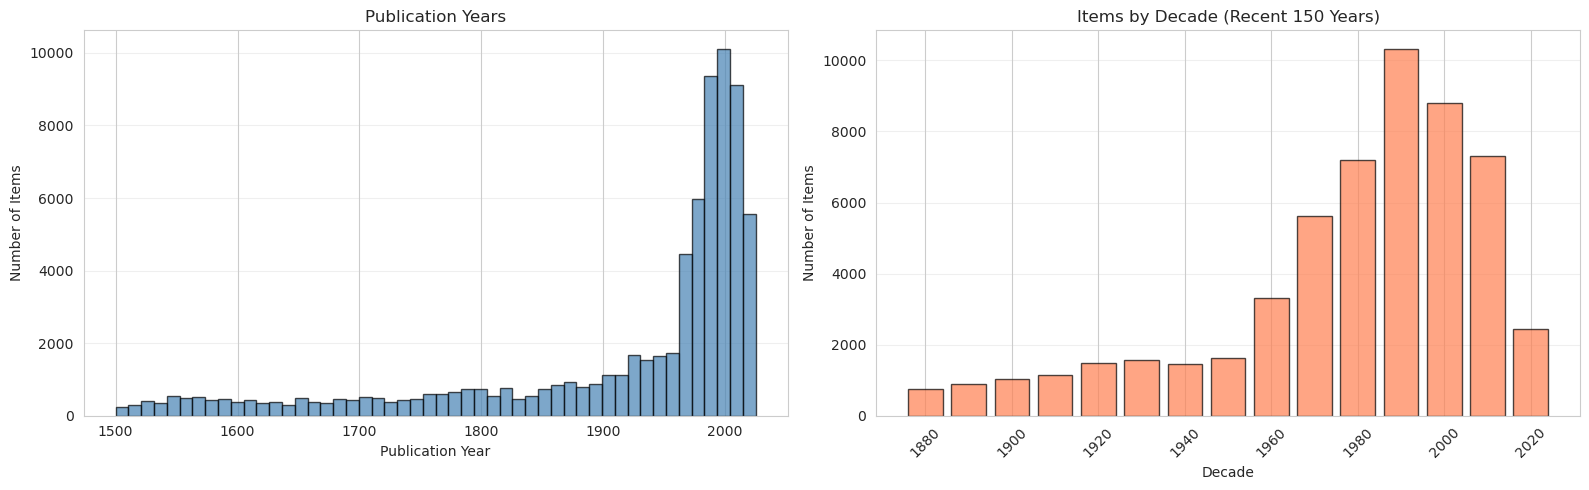


🔗 Optional accuracy check: comparing TSV-derived years vs MARC-derived years from parquet...
   Source: work/July-2025-PODParquet/initial_parquet/penn_penn-marc21.parquet

✅ Agreement where both present: 71,568/73,188 (97.8%)

⚠️ Sample disagreements (up to 5):
            F001                                                                                            Publication  pub_year_tsv  pub_year_marc
9972372123503681                                                                                New York : ROC, [1988].        1988.0         1990.0
9977500755103681 London : Frances Lincoln Children's Books : Distributed. in USA by Publishers Group West, 2005, ©1999.        1999.0         2005.0
9977224347603681                        En Córdoba : En la Imprenta de D. Juan de Medina, Plazuela de las Cañas, [1779]        1779.0         2013.0
9979408524203681                                                                    London : Cathay Books, 1988, ©1975.        1975.0        

In [38]:
# TSV-only publication year analysis (no parquet / Spark)
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("📅 TSV-ONLY PUBLICATION DATE ANALYSIS (no parquet)")
print("="*80)

# Ensure we have a DataFrame `df` from the TSV
if 'df' not in globals():
    try:
        from pathlib import Path
        # Reuse the same default path as the earlier TSV loader cell
        tsv_path = Path("/home/jovyan/work/findings/unique-at-penn-20251009-210658-csv.tsv")
        df = pd.read_csv(tsv_path, sep='\t', dtype={'F001': str, 'OCLC': str, 'ISBN': str, 'LCCN': str})
        print(f"✓ Loaded TSV on-demand: {len(df):,} rows from {tsv_path}")
    except Exception as e:
        raise RuntimeError("TSV DataFrame 'df' not found and auto-load failed. Please run the TSV analysis cell first.") from e

if 'Publication' not in df.columns:
    raise RuntimeError("TSV does not contain a 'Publication' column. TSV-only year extraction requires this field.")

# Conservative parser for 4-digit years in 1500..2099
YEAR_REGEX = re.compile(r"(1[5-9]\d{2}|20\d{2})")

# Heuristics:
# - Normalize string: strip brackets and extra punctuation where safe
# - Accept copyright/approx markers (c, ©, ca., ?), but they don't affect the 4-digit match
# - If multiple years appear, prefer the earliest year (more conservative for ranges)
# - Skip patterns like '19--' or '199-' that don't provide a full year

def _normalize_pub_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    # Remove outer brackets/braces commonly used for uncertain dates
    normalized = text.strip()
    normalized = normalized.replace("[", " ").replace("]", " ")
    normalized = normalized.replace("{", " ").replace("}", " ")
    # Remove common leading markers
    normalized = normalized.replace("©", " ").replace("c ", " ").replace("c", " ")
    normalized = normalized.replace("ca.", " ")
    # Collapse whitespace
    normalized = re.sub(r"\s+", " ", normalized)
    return normalized.strip()


def parse_year_from_publication(pub_val):
    if pd.isna(pub_val):
        return np.nan
    text = _normalize_pub_text(str(pub_val))

    # Discard incomplete placeholders like '19--' or '199-'
    if re.search(r"\b\d{2}(?:--|–)\b", text) or re.search(r"\b\d{3}-\b", text):
        # Keep scanning in case there's also a full 4-digit year elsewhere
        pass

    matches = YEAR_REGEX.findall(text)
    if not matches:
        return np.nan

    # Convert to integers and keep only plausible years
    years = []
    for m in matches:
        try:
            y = int(m)
            if 1500 <= y <= 2099:
                years.append(y)
        except Exception:
            continue

    if not years:
        return np.nan

    # For ranges like '1890-1895' both 1890 and 1895 may appear; choose earliest for conservatism
    return int(min(years))

# Apply parser
pub_series = df['Publication'].astype(str, errors='ignore') if 'Publication' in df.columns else pd.Series([], dtype=str)
df['pub_year_tsv'] = pub_series.apply(parse_year_from_publication)

# Coverage
total_items = len(df)
with_year = int(df['pub_year_tsv'].notna().sum())
without_year = total_items - with_year
print(f"\n📊 TSV-derived Publication Year Coverage:")
print(f"  Total items: {total_items:,}")
print(f"  With publication year: {with_year:,} ({with_year/total_items*100:.1f}%)")
print(f"  Without publication year: {without_year:,} ({without_year/total_items*100:.1f}%)")

# Inspect a few unparsed/ambiguous examples
ambiguous = df[df['pub_year_tsv'].isna() & df['Publication'].notna()]
if len(ambiguous) > 0:
    print(f"\n🔎 Sample ambiguous/unparsed Publication strings (up to 5):")
    print(ambiguous[['F001','Publication']].head(5).to_string(index=False))

# Distribution stats and visuals
years_only = df['pub_year_tsv'].dropna().astype(int)
if len(years_only) > 0:
    print(f"\n📈 TSV Publication Year Statistics:")
    print(f"  Earliest: {int(years_only.min())}")
    print(f"  Latest: {int(years_only.max())}")
    print(f"  Median: {int(years_only.median())}")
    print(f"  Mean: {years_only.mean():.1f}")

    years_df = pd.DataFrame({'year': years_only})
    years_df['decade'] = (years_df['year'] // 10) * 10
    decade_counts = years_df['decade'].value_counts().sort_index()

    print(f"\n📅 TSV Distribution by Decade (last 20 shown):")
    for decade, count in decade_counts.tail(20).items():
        pct = (count / len(years_only)) * 100
        bar = '█' * int(pct / 2)
        print(f"  {int(decade)}s: {count:>5,} ({pct:>5.1f}%) {bar}")

    years_df['century'] = ((years_df['year'] - 1) // 100) + 1
    century_counts = years_df['century'].value_counts().sort_index()
    century_names = {
        16: '16th (1500-1599)',
        17: '17th (1600-1699)',
        18: '18th (1700-1799)',
        19: '19th (1800-1899)',
        20: '20th (1900-1999)',
        21: '21st (2000-2099)'
    }

    print(f"\n🏛️ TSV Distribution by Century:")
    for century, count in century_counts.items():
        pct = (count / len(years_only)) * 100
        century_label = century_names.get(century, f'{century}th')
        bar = '█' * int(pct / 5)
        print(f"  {century_label}: {count:>6,} ({pct:>5.1f}%) {bar}")

    # Visuals
    print(f"\n📊 Creating TSV-only visualizations...")
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # 1) Histogram of publication years
    ax1 = axes[0]
    ax1.hist(years_only, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    ax1.set_xlabel('Publication Year')
    ax1.set_ylabel('Number of Items')
    ax1.set_title('Publication Years')
    ax1.grid(axis='y', alpha=0.3)

    # 2) Decade bar chart (last 15 decades)
    ax2 = axes[1]
    recent_decades = decade_counts.tail(15)
    ax2.bar(recent_decades.index.astype(int), recent_decades.values, width=8, edgecolor='black', alpha=0.7, color='coral')
    ax2.set_xlabel('Decade')
    ax2.set_ylabel('Number of Items')
    ax2.set_title('Items by Decade (Recent 150 Years)')
    ax2.grid(axis='y', alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ No TSV-derived publication years were found.")

# Optional agreement check vs MARC parquet (runs only if parquet is available)
try:
    parquet_candidates = [
        "work/July-2025-PODParquet/initial_parquet/penn_penn-marc21.parquet",
        "/home/jovyan/work/July-2025-PODParquet/initial_parquet/penn_penn-marc21.parquet",
        os.path.join(globals().get('output_dir', ''), 'penn_penn-marc21.parquet') if 'output_dir' in globals() else None,
    ]
    parquet_candidates = [p for p in parquet_candidates if p]
    parquet_path = next((p for p in parquet_candidates if os.path.exists(p)), None)

    if parquet_path is not None and 'spark' in globals():
        print(f"\n🔗 Optional accuracy check: comparing TSV-derived years vs MARC-derived years from parquet...\n   Source: {parquet_path}")
        from pyspark.sql import functions as F
        from pyspark.sql.types import IntegerType

        def extract_year_from_f008(v):
            if v and isinstance(v, str) and len(v) >= 11 and v[7:11].isdigit():
                y = int(v[7:11])
                return y if 1500 <= y <= 2099 else None
            return None
        def extract_year_from_field(arr):
            if isinstance(arr, list) and len(arr) > 0:
                m = re.search(r'(1[5-9]\d{2}|20\d{2})', str(arr[0]))
                if m:
                    y = int(m.group(1))
                    return y if 1500 <= y <= 2099 else None
            return None

        f008_udf = F.udf(extract_year_from_f008, IntegerType())
        ffield_udf = F.udf(extract_year_from_field, IntegerType())

        marc = spark.read.parquet(parquet_path).select('F001','F008','F260','F264')
        id_set = set(df['F001'].astype(str))
        marc = marc.filter(F.col('F001').isin(list(id_set)))
        marc = (marc
            .withColumn('y_f008', f008_udf(F.col('F008')))
            .withColumn('y_f260', ffield_udf(F.col('F260')))
            .withColumn('y_f264', ffield_udf(F.col('F264')))
            .withColumn('pub_year_marc', F.coalesce('y_f008','y_f260','y_f264'))
        )
        marc_dedup = marc.groupBy('F001').agg(F.first('pub_year_marc', ignorenulls=True).alias('pub_year_marc'))
        marc_pdf = marc_dedup.toPandas()

        merged = df[['F001','Publication','pub_year_tsv']].merge(marc_pdf, on='F001', how='left')
        both = merged.dropna(subset=['pub_year_tsv','pub_year_marc'])
        agree = int((both['pub_year_tsv'].astype(int) == both['pub_year_marc'].astype(int)).sum())
        total_cmp = len(both)
        if total_cmp > 0:
            rate = agree / total_cmp * 100
            print(f"\n✅ Agreement where both present: {agree:,}/{total_cmp:,} ({rate:.1f}%)")
        else:
            print("\nℹ️ No overlapping records with both TSV and MARC years present for comparison.")

        # Show a few disagreements if any
        diff = both[both['pub_year_tsv'].astype(int) != both['pub_year_marc'].astype(int)]
        if len(diff) > 0:
            print("\n⚠️ Sample disagreements (up to 5):")
            print(diff[['F001','Publication','pub_year_tsv','pub_year_marc']].head(5).to_string(index=False))
    else:
        print("\nℹ️ Skipping optional parquet accuracy check (parquet not found or Spark not active).")
except Exception as e:
    print(f"\n⚠️ Optional parquet accuracy check failed: {e}")

print("\n" + "="*80)
print("✅ TSV-only publication date analysis complete!")
print("="*80)